## Cross-Validation / Hyperparameter Tuning with MLPClassifier
In this notebook we make use of the MLPClassifier which is a Multi-layer Perceptron classifier that is part of sklearn

In [3]:
#import custom modules
from importlib import reload
from helpers.my_imports import *
import helpers.preprocessing as pp
import helpers.plot as plot
import helpers.tools as tools
import helpers.transformers as xfrs
from helpers.reload import myreload

#import os
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import F1Score
from sklearn.neural_network import MLPClassifier

#make sure latest copy of library is loaded
myreload()

#Global Variable for Random State
rs=42 #random_state

#Reload dataframe
df = pd.read_csv('saved_dfs/preprocessed_negotiations_df.csv')

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


## Define X, y
Redefine X and y based on what we learned in Feature Engineering

In [4]:
#Define X and y
X,y=df.drop(columns=['decision', 'billed_amount', 'negotiation_amount', 'offer', 'counter_offer']), df.decision

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)

#Split and stratify the data
X_train, X_test, y_train, y_test = train_test_split(X,encoded_y, stratify=None, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6398, 20), (2133, 20), (6398,), (2133,))

### Define Scoring Metrics

In [5]:
scoring_metrics = {
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0.0),
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0.0)
}

### MLPClassifier Cross-Validation/HyperParameter Tuning Sets

#### Set 1 - Broad Parameters

Fitting 5 folds for each of 40 candidates, totalling 200 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__early_stopping,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__solver,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision_weighted
1,0.933009,Yes,0.974237,0.927998,2.854708,0.941849,tanh,0.001000,128,True,"(64, 32, 16)",adaptive,0.010000,adam,0.000417,292,0.600000,0.000001,0,1,None,6
2,0.932412,Yes,0.962961,0.931733,2.366121,0.939187,relu,0.000100,128,True,"(64, 32, 16)",adaptive,0.001000,adam,0.000025,200,0.500000,0.000014,0,1,None,18


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__early_stopping,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__solver,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__num__poly__degree,param_transformer__ohe__drop,rank_test_precision_weighted,holdout_rank_f1_weighted
28,0.920188,No,0.924030,0.928986,6.770541,0.940348,logistic,0.00001,512,True,"(64, 32)",invscaling,0.001,adam,0.000033,243,0.55,0.000004,0.0025,2,if_binary,11,1
37,0.917577,No,0.921124,0.925345,5.186906,0.938826,logistic,0.0001,256,True,"(64, 32)",invscaling,0.001,adam,0.00012,143,0.45,0.000001,0.005,2,if_binary,20,2
26,0.921345,No,0.922295,0.925048,1.873246,0.941012,logistic,0.00001,128,True,"(64, 32, 16)",constant,0.001,adam,0.000097,187,0.55,0.000005,0.005,1,None,10,3
31,0.919370,No,0.922548,0.924551,29.226558,0.941457,logistic,0.00001,512,True,"(64, 32)",constant,0.001,adam,0.000021,214,0.5,0.000054,0.0075,3,None,8,4
14,0.926704,Yes,0.959026,0.933881,1.990947,0.933813,logistic,0.0001,512,True,"(64, 32, 16)",invscaling,0.1,adam,0.000172,247,0.55,0.000015,0.005,1,if_binary,40,5


<Figure size 640x480 with 0 Axes>

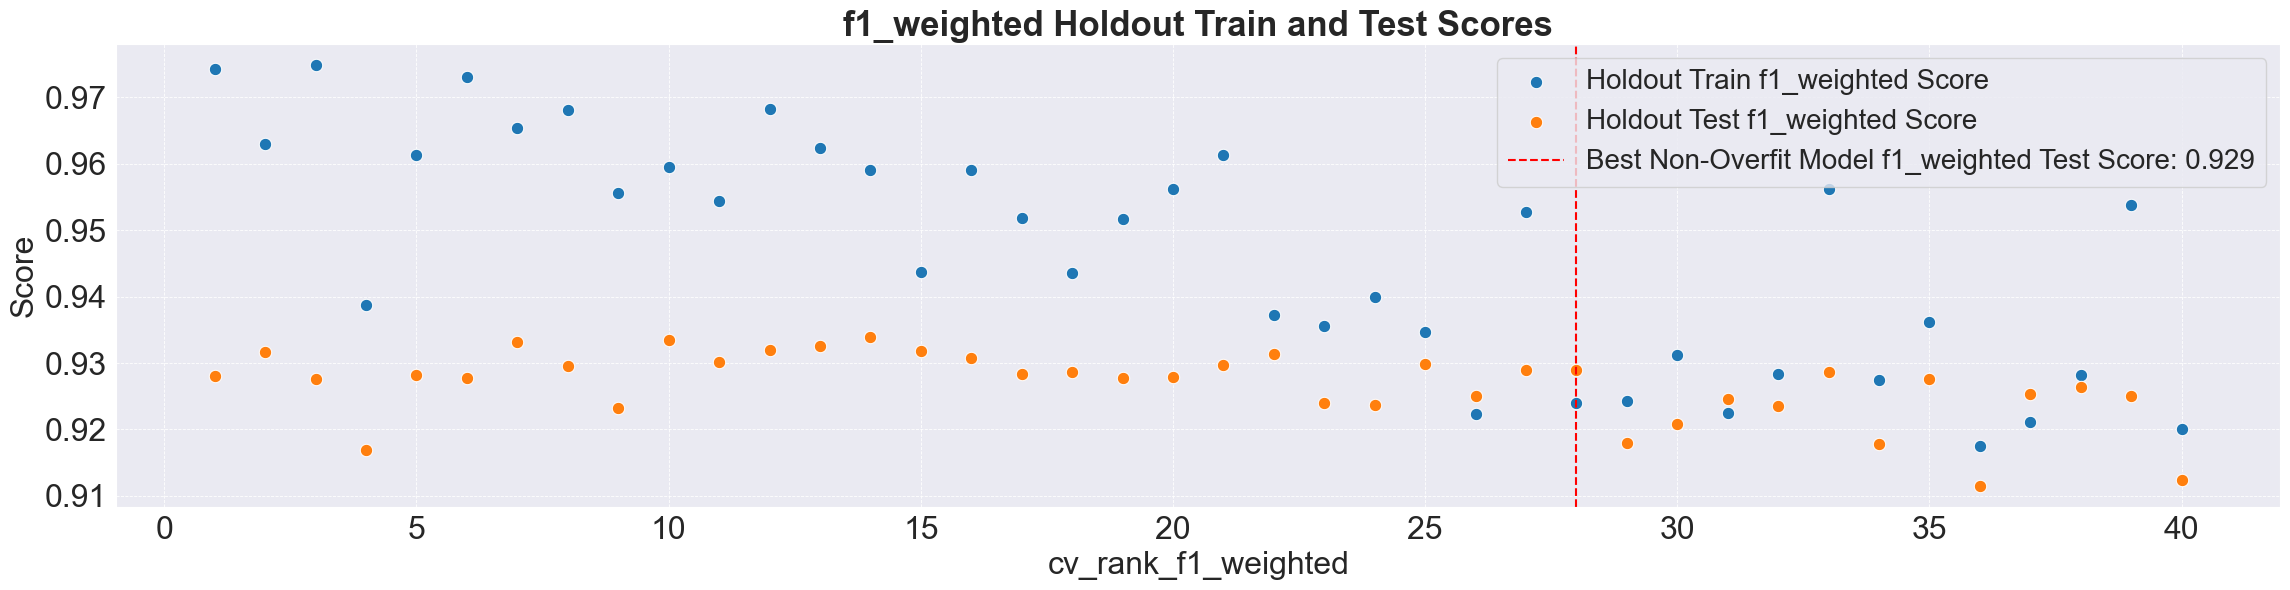

In [5]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(include_bias=False)),        
    poly_params={'transformer__num__poly__degree':[1,2,3]}, 
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075, 0.01]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary', None]},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.6, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),     
                           
    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 1e-4) },  
    
    estimator_dicts = [{
        'est_tuple': ('MLP', MLPClassifier(max_iter=200, random_state=rs)), 
        'est_params': {
            'hidden_layer_sizes': [(64,32), (64,32,16)],
            'activation': ['relu', 'tanh', 'logistic'], 
            'solver': ['adam'], #, 'sgd'], 
            'alpha': [0.00001, 0.0001, 0.001], 
            'batch_size': [128, 256, 512], 
            'learning_rate':['constant','invscaling', 'adaptive'],
            'learning_rate_init':[0.001, 0.01,0.1], 
            #'power_t': [0.4,0.5,0.6],
            'tol': loguniform(1e-5, 1e-3),
            #'momentum'and nestevrovs_momentum
            'early_stopping': [True],
        }, },], set_name= 'ht_mlp_set1',         
    cv=5, n_iter=40, summary=True, verbose=1, test_size=0.25, stratify=y,rs=rs)

#### Set 2: Remove polynomial features

Fitting 5 folds for each of 40 candidates, totalling 200 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__early_stopping,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__solver,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__ohe__drop,rank_test_precision_weighted
1,0.932705,Yes,0.962758,0.927948,1.703540,0.940256,relu,0.000100,512,True,"(20, 10, 5)",constant,0.010000,adam,0.000220,262,0.600000,0.000071,0.002500,if_binary,7
2,0.930779,Yes,0.964345,0.930961,2.501143,0.937915,relu,0.000100,512,True,"(20, 10, 5)",constant,0.010000,adam,0.000155,270,0.550000,0.000059,0,None,18


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__early_stopping,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__solver,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__ohe__drop,rank_test_precision_weighted,holdout_rank_f1_weighted
25,0.914896,No,0.924605,0.925426,1.835007,0.940498,logistic,0.000001,128,True,"(20, 10)",constant,0.001,adam,0.000225,254,0.55,0.000014,0.005,if_binary,6,1
32,0.902776,No,0.919956,0.921355,1.871929,0.929889,relu,0.00001,256,True,"(20, 10)",adaptive,0.0001,adam,0.000048,158,0.55,0.000031,0.0025,if_binary,34,2
28,0.911946,No,0.918985,0.919647,1.265200,0.938638,logistic,0.000001,256,True,"(20, 10, 5)",constant,0.001,adam,0.000014,186,0.4,0.000004,0.0075,if_binary,13,3
18,0.921143,No,0.916424,0.919442,1.863694,0.939449,tanh,0.0001,256,True,"(20, 10)",adaptive,0.001,adam,0.000071,208,0.6,0.000002,0.0025,if_binary,10,4
29,0.907920,No,0.913087,0.916277,1.634768,0.932837,tanh,0.0001,128,True,"(20, 10, 5)",constant,0.0001,adam,0.000069,187,0.55,0.000005,0.005,if_binary,31,5


<Figure size 640x480 with 0 Axes>

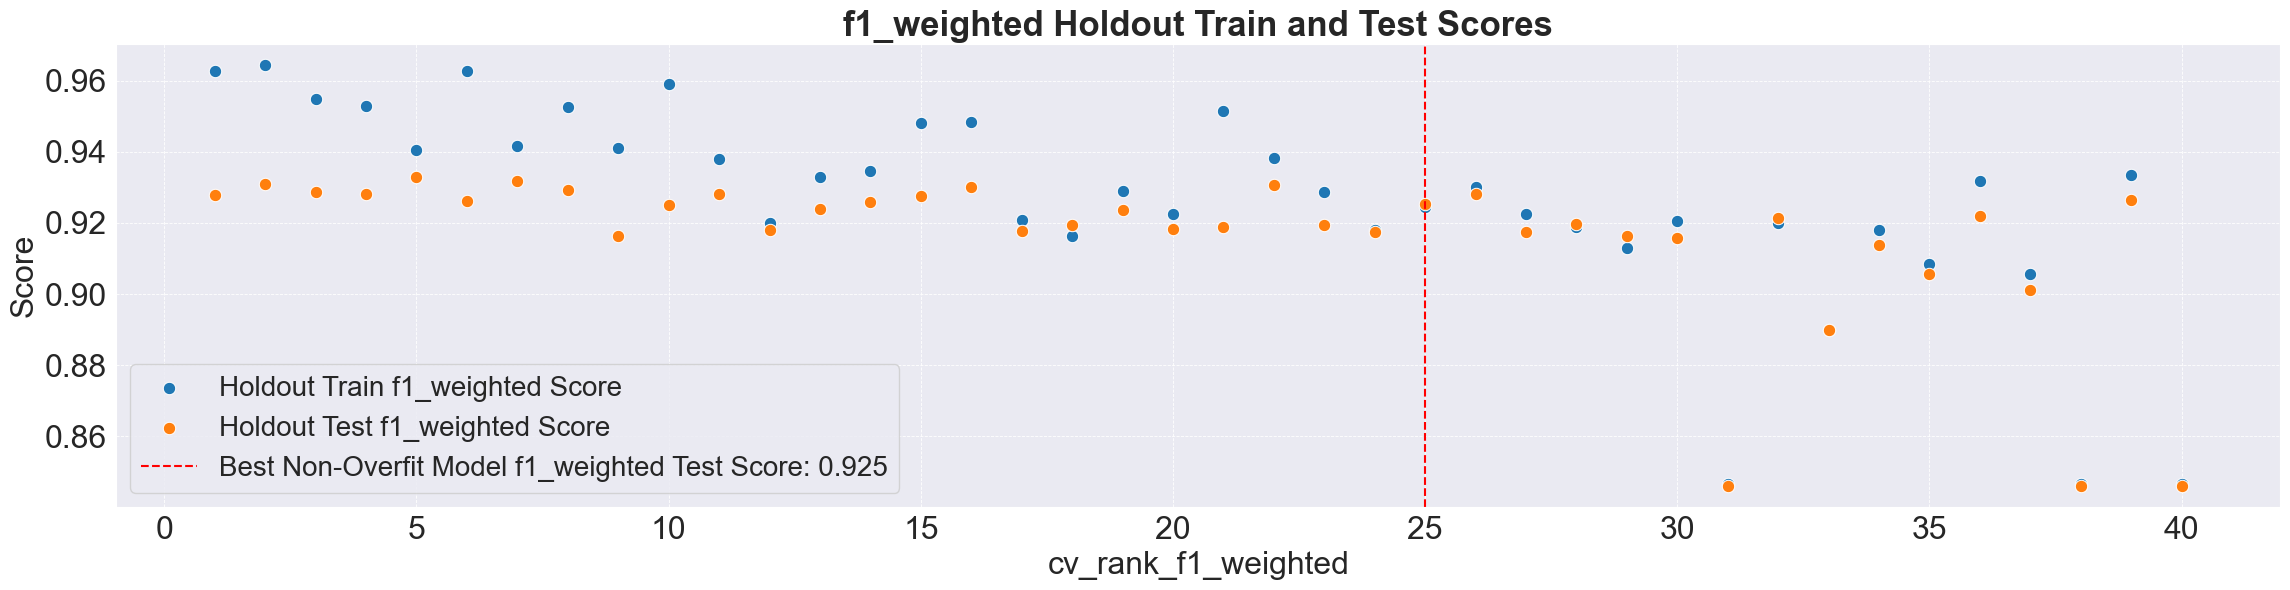

In [6]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075, 0.01]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary', None]},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.6, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),     
                           
    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 1e-4) },  
    
    estimator_dicts = [{
        'est_tuple': ('MLP', MLPClassifier(max_iter=200, random_state=rs)), 
        'est_params': {
            'hidden_layer_sizes': [(20,10,5), (20,10)], #[(64,32), (80,40,10)],
            'activation': ['relu', 'tanh', 'logistic'], 
            'solver': ['adam'], #, 'sgd'], 
            'alpha': [0.000001, 0.00001, 0.0001], 
            'batch_size': [128, 256, 512], 
            'learning_rate':['constant','invscaling', 'adaptive'],
            'learning_rate_init':[0.0001, 0.001, 0.01], 
            #'power_t': [0.4,0.5,0.6],
            'tol': loguniform(1e-5, 5e-4),
            #'momentum'and nestevrovs_momentum
            'early_stopping': [True],
        }, },], set_name= 'ht_mlp_set2',         
    cv=5, n_iter=40, summary=True, verbose=1, test_size=0.25, stratify=y,rs=rs)

#### Set 3 Update params to reduce overfitting

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.
Fitting 5 folds for each of 30 candidates, totalling 150 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__max_iter,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__ohe__drop,rank_test_precision_weighted
1,0.926745,Yes,0.944133,0.923567,1.406769,0.939519,relu,0.100000,128,"(10, 5)",invscaling,0.010000,100,0.000168,281,0.500000,0.000011,0.002500,None,8
2,0.925946,Yes,0.934394,0.927478,1.154734,0.938178,relu,0.010000,256,"(15, 10, 5)",invscaling,0.010000,100,0.000039,268,0.500000,0.000023,0.010000,None,12


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__max_iter,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__ohe__drop,rank_test_precision_weighted,holdout_rank_f1_weighted
17,0.914511,No,0.917047,0.919050,1.472176,0.939557,logistic,0.01,128,"(15, 10, 5)",invscaling,0.001,200,0.00002,160,0.4,0.000004,0.01,None,7,1
23,0.845040,No,0.901427,0.903631,1.000596,0.893150,logistic,0.01,1024,"(10, 5)",constant,0.001,300,0.000052,189,0.4,0.000017,0.0075,None,23,2
25,0.820473,No,0.848542,0.859848,1.878464,0.899816,relu,0.001,1024,"(10, 5)",invscaling,0.0001,300,0.000101,286,0.45,0.000011,0.005,None,22,3
27,0.681034,No,0.761519,0.764659,1.131905,0.643961,logistic,0.001,512,"(10, 5)",constant,0.0001,300,0.000057,214,0.5,0.000054,0.0075,None,27,4
26,0.681286,No,0.019685,0.019791,1.321618,0.644241,logistic,0.001,1024,"(15, 10, 5)",invscaling,0.0001,300,0.000034,176,0.5,0.000015,0.005,if_binary,26,5


<Figure size 640x480 with 0 Axes>

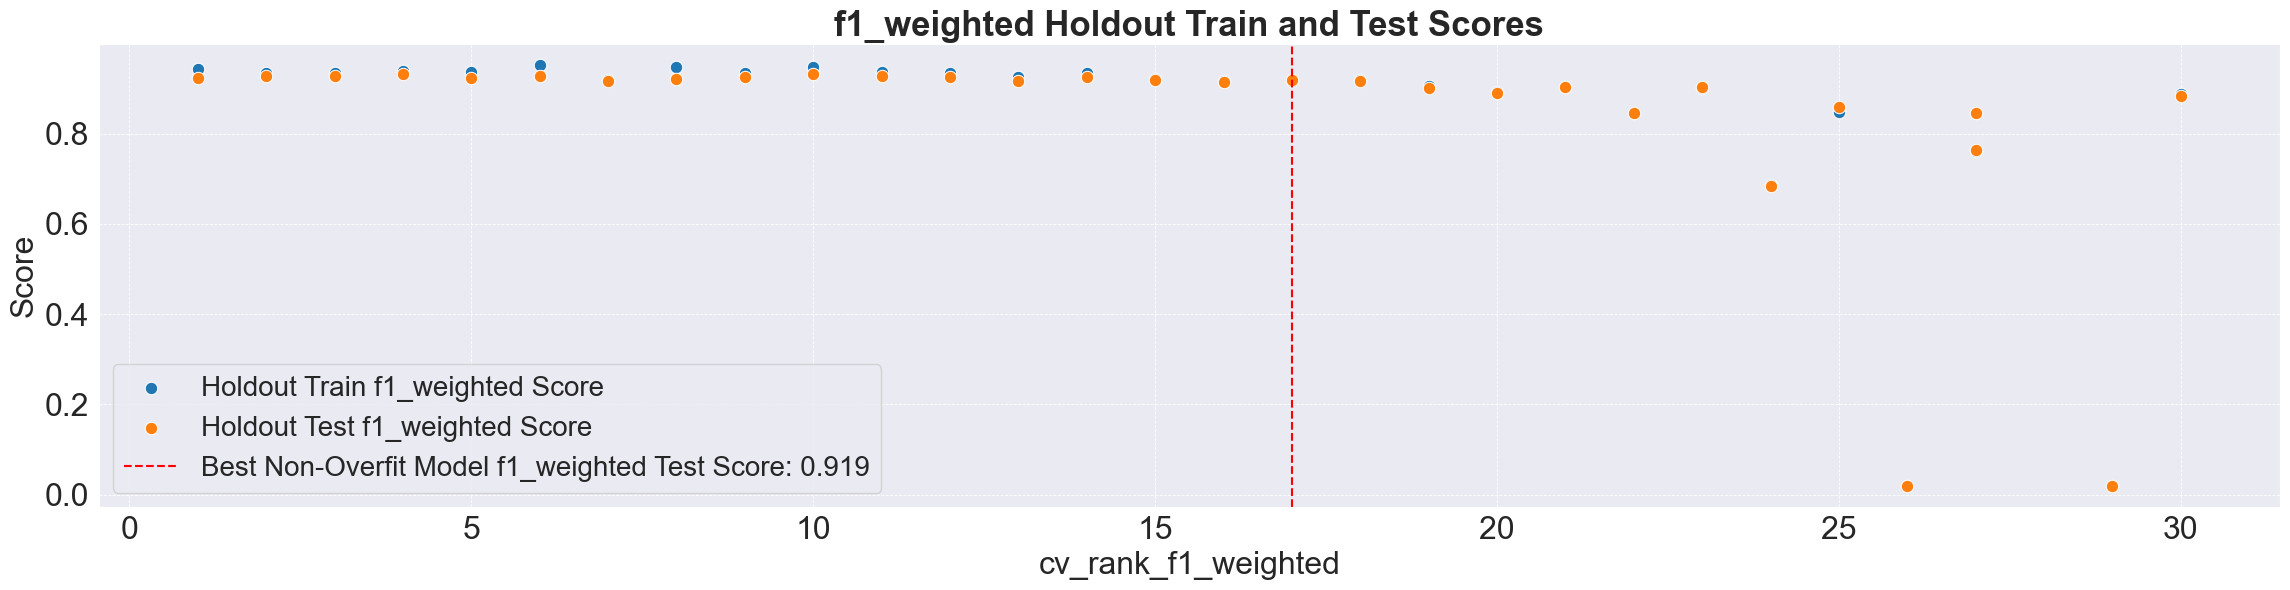

In [7]:
myreload()
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   

    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075, 0.01]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary', None]},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.6, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),     
                           
    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 1e-4) },  
    
    estimator_dicts = [{
        'est_tuple': ('MLP', MLPClassifier(solver='adam', early_stopping=True, random_state=rs)), 
        'est_params': {
            'hidden_layer_sizes': [(10, 5), (15, 10, 5)],
            'activation': ['relu', 'tanh', 'logistic'], 
            'alpha': [0.001, 0.01, 0.1],
            'batch_size': [128, 256, 512, 1024],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'learning_rate_init': [0.0001, 0.001, 0.01],
            'tol': loguniform(1e-5, 5e-4),
            'max_iter': [100, 200, 300]
        }, },], set_name= 'ht_mlp_set3',         
    cv=5, n_iter=30, summary=True, verbose=1, test_size=0.25, stratify=y,rs=rs)

#### Set 4: Modify hidden layer sizes 

Fitting 5 folds for each of 40 candidates, totalling 200 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__max_iter,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__ohe__drop,rank_test_precision_weighted
1,0.929441,Yes,0.934352,0.925985,2.254156,0.937198,relu,0.100000,512,"(20, 15, 10)",invscaling,0.010000,100,0.000016,168,0.550000,0.000001,0,None,14
2,0.926201,Yes,0.946824,0.921578,2.509772,0.940412,relu,0.100000,512,"(15, 10, 5)",constant,0.010000,300,0.000204,144,0.450000,0.000005,0,None,3


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__max_iter,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__ohe__drop,rank_test_precision_weighted,holdout_rank_f1_weighted
19,0.918133,No,0.919025,0.921010,1.921938,0.937622,relu,0.001,128,"(20, 15, 10)",invscaling,0.0001,100,0.000092,238,0.55,0.000006,0.01,None,12,1
27,0.912070,No,0.918735,0.920605,1.398100,0.938731,logistic,0.01,128,"(20, 15, 10)",invscaling,0.001,200,0.00002,160,0.4,0.000004,0.01,None,8,2
34,0.543329,No,0.913408,0.915925,1.672704,0.559917,logistic,0.001,1024,"(15, 10, 5)",constant,0.001,200,0.000325,282,0.55,0.000014,0.005,if_binary,34,3
28,0.901502,No,0.908657,0.914068,2.260416,0.930238,relu,0.001,512,"(20, 15, 10)",invscaling,0.0001,200,0.000083,194,0.55,0.000002,0.0025,None,27,4
30,0.885778,No,0.910815,0.912009,2.342460,0.927462,tanh,0.001,256,"(15, 10, 5)",adaptive,0.0001,100,0.000025,187,0.5,0.000014,0,None,29,5


<Figure size 640x480 with 0 Axes>

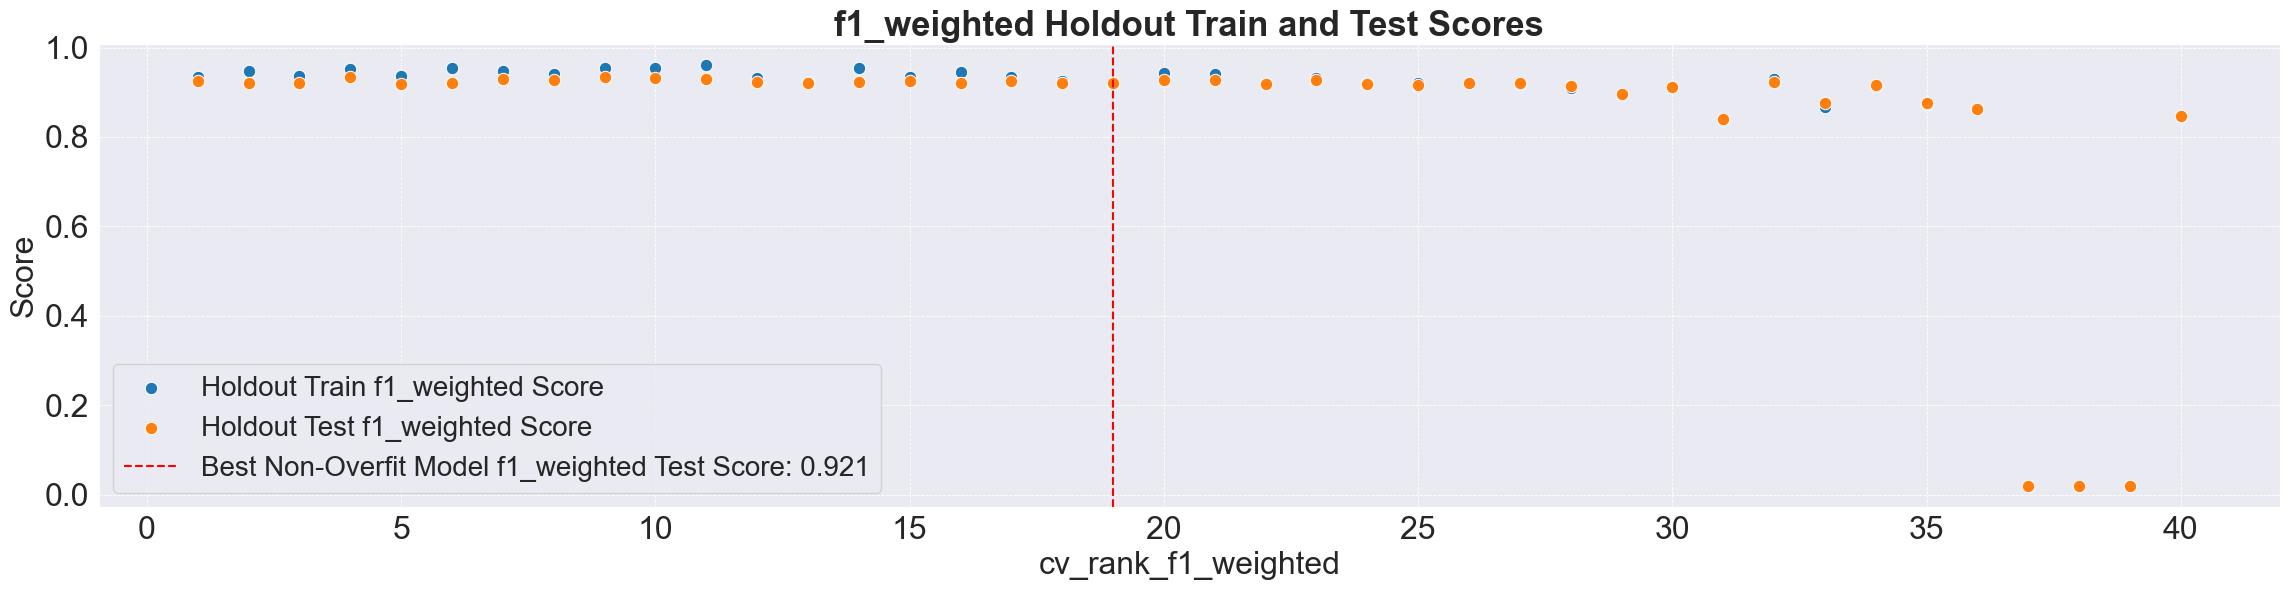

In [8]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
     
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075, 0.01]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary', None]},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.6, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),     
                           
    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 1e-4) },  
    
    estimator_dicts = [{
        'est_tuple': ('MLP', MLPClassifier(solver='adam', early_stopping=True, random_state=rs)), 
        'est_params': {
            'hidden_layer_sizes': [(15, 10, 5), (20, 15, 10)],
            'activation': ['relu', 'tanh', 'logistic'], 
            'alpha': [0.001, 0.01, 0.1],
            'batch_size': [128, 256, 512, 1024],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'learning_rate_init': [0.0001, 0.001, 0.01],
            'tol': loguniform(1e-5, 5e-4),
            'max_iter': [100, 200, 300]
        }, },], set_name= 'ht_mlp_set4',         
    cv=5, n_iter=40, summary=True, verbose=1, test_size=0.25, stratify=y,rs=rs)

#### Set 5 replace 15,10,5 hidden layers with more complex layers, keep 20,15,10 as baseline

Fitting 5 folds for each of 40 candidates, totalling 200 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__max_iter,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted
1,0.929681,Yes,0.967100,0.928988,2.247120,0.937942,logistic,0.010000,128,"(20, 15, 10)",constant,0.010000,100,0.000021,200,0.500000,0.000014,0,11
2,0.926512,Yes,0.936463,0.923589,1.409626,0.939715,relu,0.100000,512,"(20, 15, 10, 5)",invscaling,0.001000,200,0.000236,273,0.550000,0.000040,0.007500,6


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__max_iter,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted,holdout_rank_f1_weighted
21,0.914841,No,0.929487,0.931120,1.644993,0.935377,relu,0.1,1024,"(20, 15, 10)",constant,0.001,300,0.000154,191,0.6,0.000087,0.0025,24,1
35,0.556829,No,0.920457,0.923913,1.378390,0.569717,logistic,0.1,256,"(20, 15, 10, 5)",invscaling,0.001,200,0.00045,248,0.5,0.000061,0.005,35,2
19,0.917062,No,0.922143,0.923416,2.042640,0.938656,tanh,0.01,128,"(20, 15, 10)",constant,0.0001,300,0.00016,178,0.6,0.000004,0.0025,9,3
28,0.909049,No,0.918348,0.923239,1.228607,0.937315,logistic,0.01,256,"(20, 15, 10)",constant,0.001,300,0.000011,286,0.45,0.00001,0.01,14,4
27,0.912070,No,0.918735,0.920605,1.486692,0.938731,logistic,0.01,128,"(20, 15, 10)",invscaling,0.001,200,0.00002,160,0.4,0.000004,0.01,8,5


<Figure size 640x480 with 0 Axes>

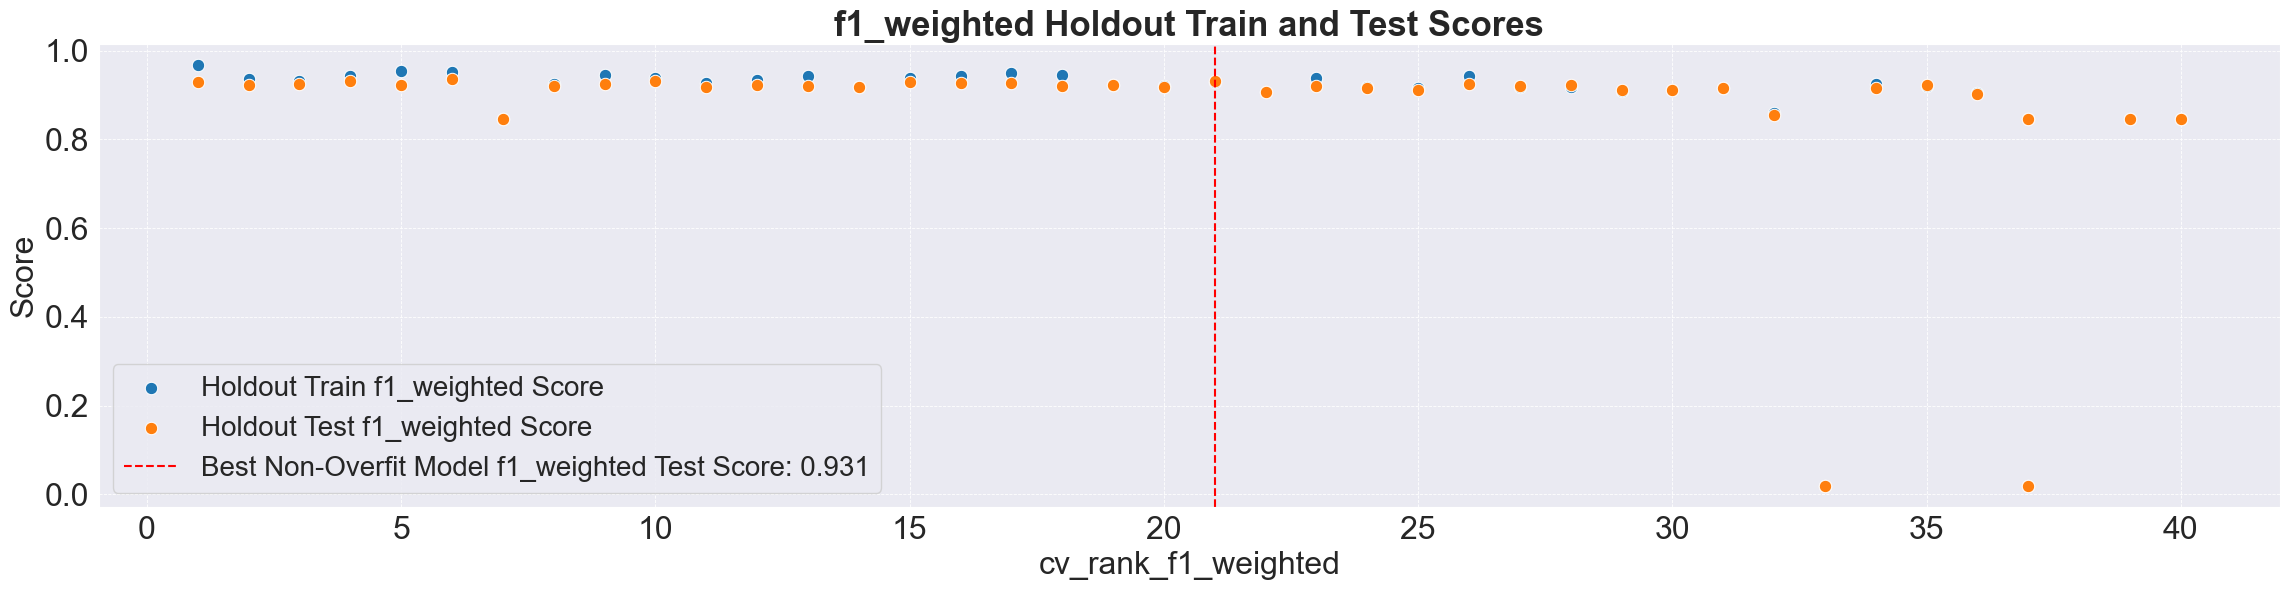

In [9]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075, 0.01]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder(drop=None))), #ohe_params={'transformer__ohe__drop':['if_binary', None]},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.6, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),     
                           
    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 1e-4) },  
    
    estimator_dicts = [{
        'est_tuple': ('MLP', MLPClassifier(solver='adam', early_stopping=True, random_state=rs)), 
        'est_params': {
            'hidden_layer_sizes': [(20, 15, 10, 5), (20, 15, 10)],
            'activation': ['relu', 'tanh', 'logistic'], 
            'alpha': [0.001, 0.01, 0.1],
            'batch_size': [128, 256, 512, 1024],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'learning_rate_init': [0.0001, 0.001, 0.01],
            'tol': loguniform(1e-5, 5e-4),
            'max_iter': [100, 200, 300]
        }, },], set_name= 'ht_mlp_set5',         
    cv=5, n_iter=40, summary=True, verbose=1, test_size=0.25, stratify=y,rs=rs)

#### Set 6 'hidden_layer_sizes': [(64, 40, 30, 20), (20, 15, 10)],

Fitting 5 folds for each of 100 candidates, totalling 500 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__max_iter,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted
1,0.931722,Yes,0.952758,0.932519,1.746484,0.936740,relu,0.010000,256,"(64, 40, 30, 20)",adaptive,0.010000,2000,0.000005,192,0.500000,0.000012,0.005000,35
2,0.931475,Yes,0.971814,0.936531,1.830449,0.933983,relu,0.150000,1250,"(64, 40, 30, 20)",adaptive,0.010000,3000,0.000034,276,0.600000,0.000024,0.002500,65


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__max_iter,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted,holdout_rank_f1_weighted
69,0.909443,No,0.922227,0.922574,1.871421,0.932435,relu,0.05,512,"(64, 40, 30, 20)",invscaling,0.0001,3000,0.000549,274,0.4,0.000018,0.0075,70,1
79,0.897875,No,0.921265,0.922282,1.309294,0.928410,relu,0.05,1024,"(20, 15, 10)",adaptive,0.001,3000,0.000262,291,0.4,0.000001,0.005,80,2
54,0.918931,No,0.919874,0.921528,2.272190,0.938217,relu,0.05,256,"(64, 40, 30, 20)",constant,0.0001,3000,0.000005,252,0.45,0.000005,0.0025,14,3
74,0.907326,No,0.913475,0.918558,2.083073,0.930503,relu,0.15,256,"(20, 15, 10)",invscaling,0.0001,3000,0.000555,238,0.55,0.000001,0.01,75,4
59,0.915282,No,0.918122,0.918277,1.215156,0.935881,relu,0.01,1024,"(20, 15, 10)",invscaling,0.001,3000,0.000263,239,0.4,0.000008,0.01,47,5


<Figure size 640x480 with 0 Axes>

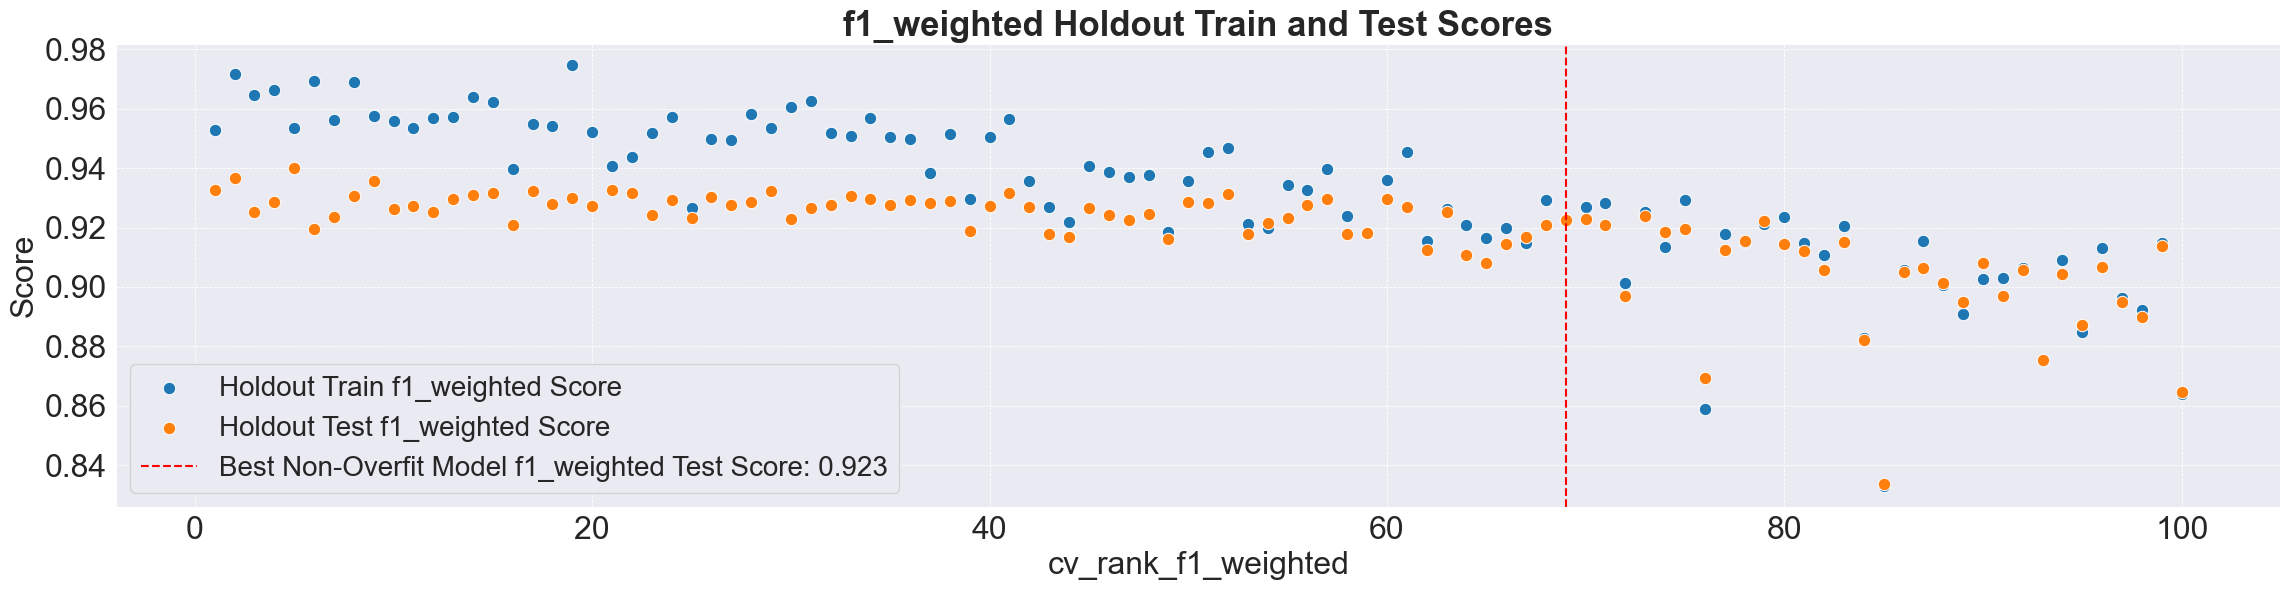

In [10]:
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005, 0.0075, 0.01]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder(drop=None))), #ohe_params={'transformer__ohe__drop':['if_binary', None]},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.6, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),     
                           
    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 1e-4) },  
    
    estimator_dicts = [{
        'est_tuple': ('MLP', MLPClassifier(solver='adam', early_stopping=True, random_state=rs)), 
        'est_params': {
            'hidden_layer_sizes': [(64, 40, 30, 20), (20, 15, 10)], #(20, 15, 10, 5), 
            'activation': ['relu'],  #'tanh', 'logistic'
            'alpha': [0.01, 0.05, 0.1, 0.15],
            'batch_size': [256, 512, 700, 1024, 1250],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'learning_rate_init': [0.0001, 0.001, 0.01],
            'tol': loguniform(1e-6, 1e-3),
            'max_iter': [2000, 3000]
        }, },], set_name= 'ht_mlp_set6',         
    cv=5, n_iter=100, summary=True, verbose=1, test_size=0.25, stratify=y,rs=rs)

#### Set 7 bring back polynomial features degree 2

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__solver,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__ohe__drop,rank_test_precision_weighted
1,0.933816,Yes,0.967648,0.928353,8.522553,0.942848,relu,0.000001,512,"(64, 32)",adaptive,0.001000,adam,0.000246,146,0.550000,0.000002,0,None,4
2,0.931982,Yes,0.975247,0.929401,9.346963,0.937842,relu,0.000010,256,"(72, 36)",constant,0.001000,adam,0.000055,176,0.600000,0.000007,0,if_binary,50


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__solver,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,param_transformer__ohe__drop,rank_test_precision_weighted,holdout_rank_f1_weighted
49,0.921553,No,0.928488,0.931667,7.250825,0.941277,relu,0.00001,256,"(64, 32)",adaptive,0.0001,adam,0.000013,286,0.55,0.000005,0.0025,if_binary,15,1
51,0.921373,No,0.930788,0.931283,5.803479,0.940635,tanh,0.0001,1024,"(64, 32)",invscaling,0.001,adam,0.000075,225,0.5,0.000009,0.005,None,22,2
58,0.919071,No,0.926184,0.929460,6.534831,0.939900,relu,0.0001,256,"(64, 32)",invscaling,0.0001,adam,0.00022,171,0.45,0.000005,0.005,None,30,3
48,0.921691,No,0.925504,0.929037,6.482357,0.940965,tanh,0.00001,512,"(72, 36)",invscaling,0.001,adam,0.000129,191,0.4,0.000011,0.005,None,18,4
64,0.916704,No,0.923723,0.928904,6.329796,0.937914,logistic,0.000001,1024,"(64, 32)",adaptive,0.001,adam,0.000499,144,0.45,0.000003,0.0025,if_binary,49,5


<Figure size 640x480 with 0 Axes>

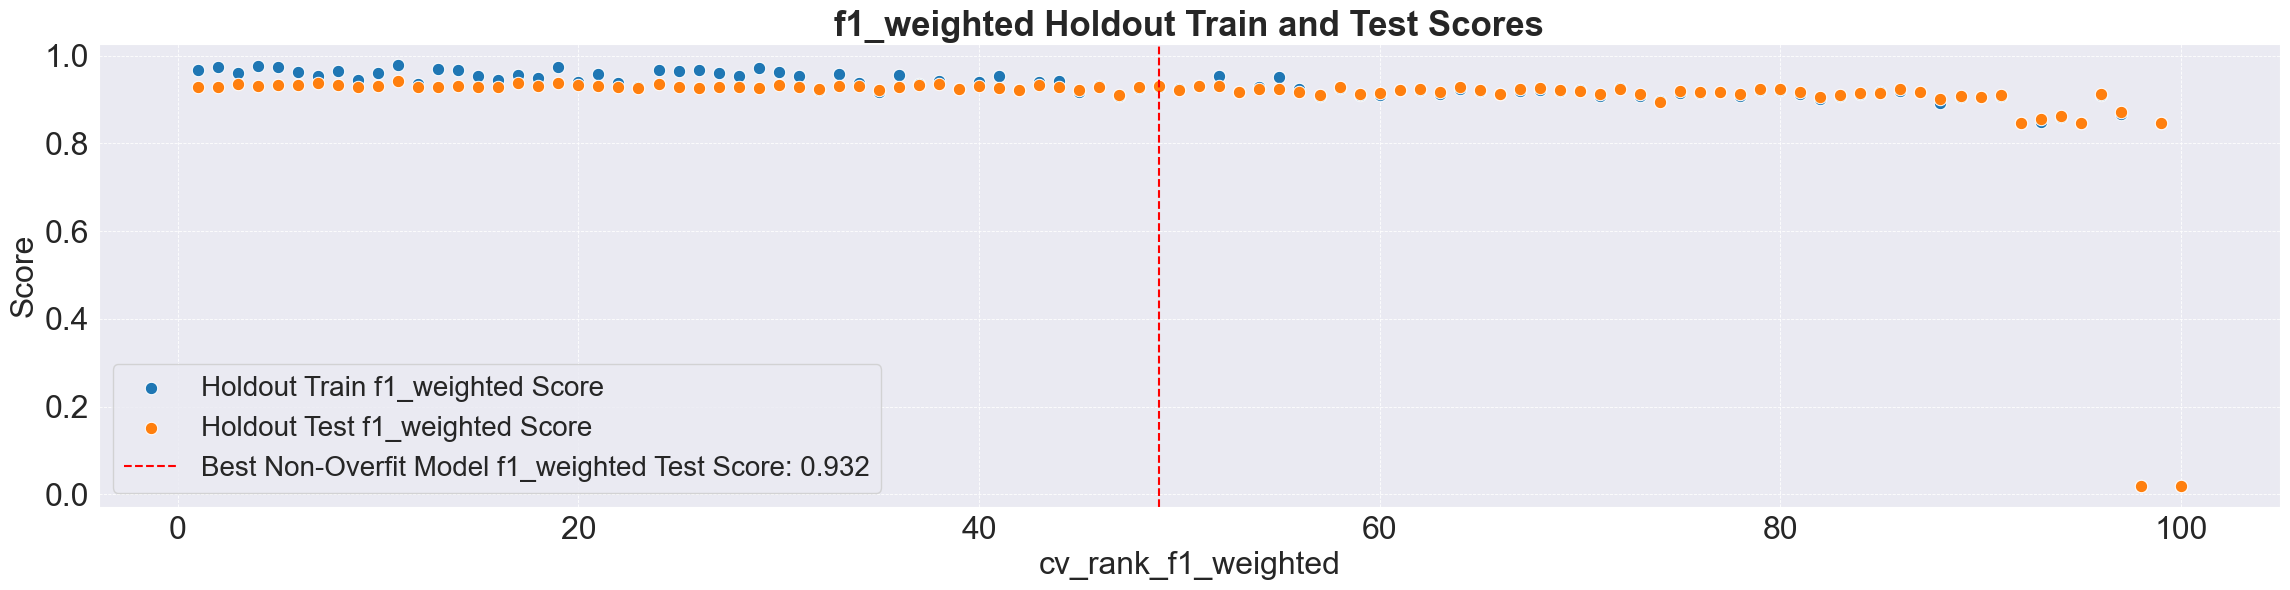

In [11]:
myreload()
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(degree=2, include_bias=False)),  #poly_params={'transformer__num__poly__degree':[]}, 
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder())),
    ohe_params={'transformer__ohe__drop':['if_binary', None]},
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.6, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),     
                           
    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 1e-4) },  
    
    estimator_dicts = [{
        'est_tuple': ('MLP', MLPClassifier(max_iter=2000, early_stopping=True, solver='adam', random_state=rs)), 
        'est_params': {
            'hidden_layer_sizes': [(64,32), (72, 36)],
            'activation': ['relu', 'tanh', 'logistic'], 
            'solver': ['adam'], #, 'sgd'], 
            'alpha': [0.000001, 0.00001, 0.0001], 
            'batch_size': [256, 512, 1024, 2046], 
            'learning_rate':['constant','invscaling', 'adaptive'],
            'learning_rate_init':[0.0001, 0.001, 0.01], 
            'tol': loguniform(1e-5, 1e-3),
            #sgd params: 'power_t': [0.4,0.5,0.6], #'momentum'and nestevrovs_momentum
        }, },], set_name= 'ht_mlp_set7',         
    cv=5, n_iter=100, summary=True, verbose=1, test_size=0.25, stratify=y,rs=rs)

#### Set 8, introduce another layer, update tolerance, set ohe drop to if_binary

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.
Fitting 5 folds for each of 100 candidates, totalling 500 fits


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted
1,0.933644,Yes,0.968215,0.933758,7.120668,0.939348,relu,0.000001,512,"(64, 32, 16)",constant,0.010000,0.000423,255,0.600000,0.000006,0.005000,33
2,0.933275,Yes,0.936180,0.932842,8.312118,0.940354,relu,0.000001,1024,"(64, 32, 16)",constant,0.001000,0.000335,162,0.600000,0.000028,0.002500,26


cv_rank_f1_weighted,cv_f1_weighted,is_overfit,train_f1_weighted,test_f1_weighted,mean_fit_time,mean_test_precision_weighted,param_MLP__activation,param_MLP__alpha,param_MLP__batch_size,param_MLP__hidden_layer_sizes,param_MLP__learning_rate,param_MLP__learning_rate_init,param_MLP__tol,param_over__k_neighbors,param_over__sampling_strategy,param_selector__threshold,param_transformer__cat__combiner__rare_to_value,rank_test_precision_weighted,holdout_rank_f1_weighted
32,0.925101,No,0.925726,0.928904,5.514152,0.941959,relu,0.000001,2046,"(64, 32, 16)",invscaling,0.001,0.000005,228,0.4,0.000011,0.005,6,1
63,0.917839,No,0.925249,0.927923,6.786620,0.939099,tanh,0.000001,256,"(64, 32, 16)",constant,0.0001,0.000007,283,0.55,0.000059,0.005,40,2
73,0.912879,No,0.923063,0.925940,7.598924,0.936481,logistic,0.000001,1024,"(64, 32, 16)",constant,0.001,0.000026,180,0.55,0.000053,0.0025,68,3
75,0.911774,No,0.922712,0.925690,8.427452,0.936659,tanh,0.000001,1024,"(64, 32, 16)",constant,0.0001,0.000022,209,0.6,0.000052,0.005,66,4
84,0.892121,No,0.922309,0.925310,6.099024,0.931006,logistic,0.000001,1024,"(64, 32, 16)",invscaling,0.001,0.000089,201,0.4,0.000002,0.0025,78,5


<Figure size 640x480 with 0 Axes>

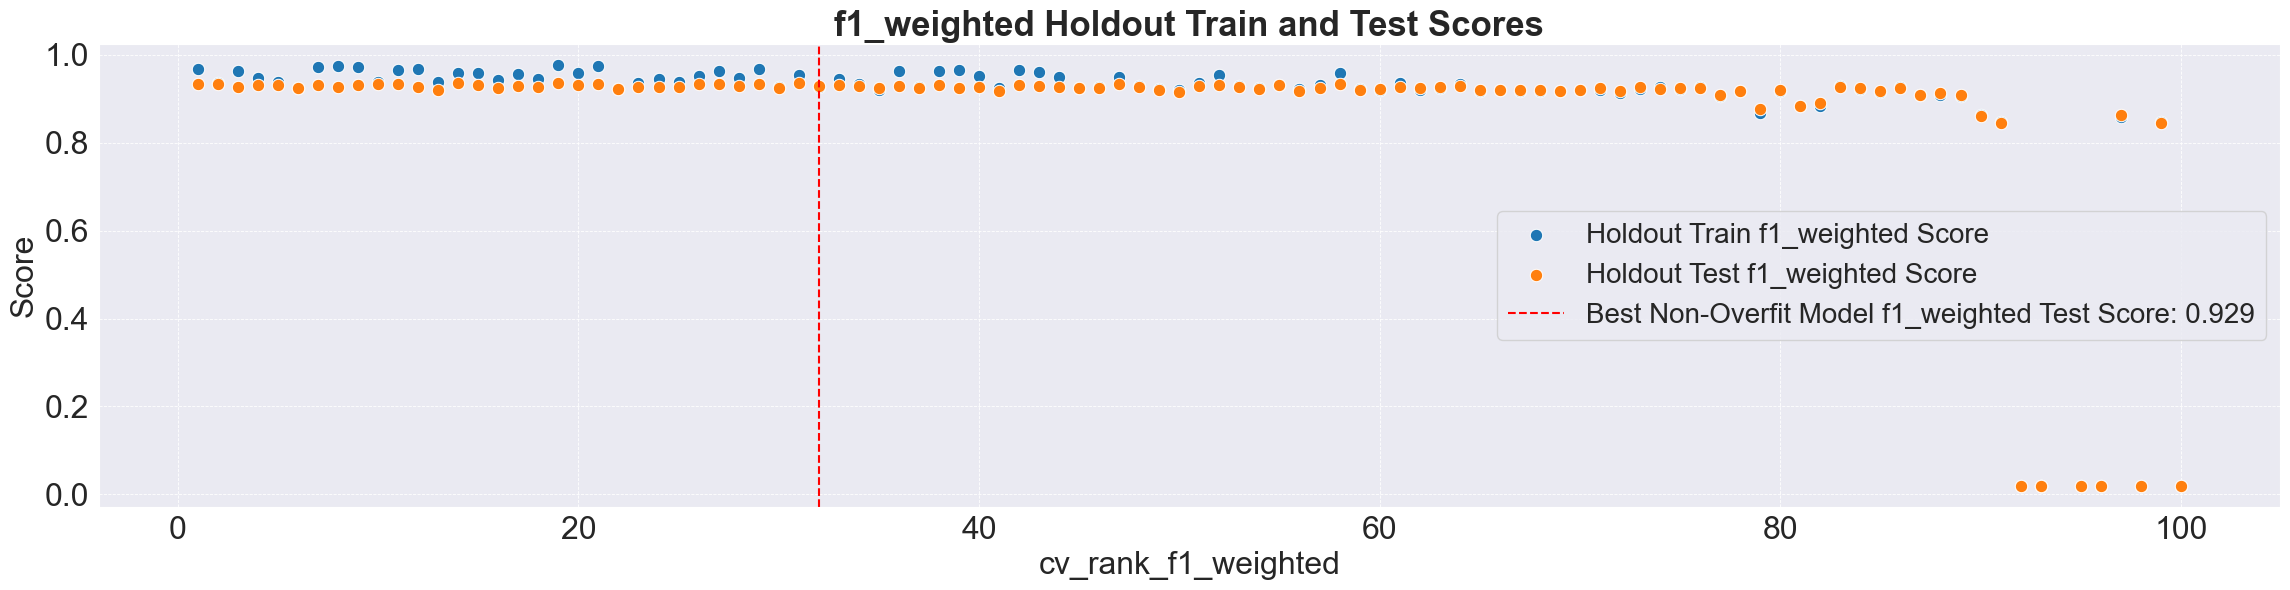

In [6]:
myreload()
tools.build_and_run_pipes (df,'decision', search_type='random', scoring_metrics = scoring_metrics,refit='f1_weighted',
    num_imputer=('si',SimpleImputer(strategy='most_frequent')), 
    num_transformer=('yeo', PowerTransformer(method='yeo-johnson')),   
    
    poly=('poly', PolynomialFeatures(degree=2, include_bias=False)),  #poly_params={'transformer__num__poly__degree':[]}, 
    num_cols=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer', 
              'offer_days', 'decision_days', 'service_days', 'counter_offer_days', 'YOB'], 
                     
    cat_combiner=('combiner', xfrs.RareCategoryCombiner()), 
    cat_combiner_params= {'transformer__cat__combiner__rare_to_value': [0, 0.0025, 0.005]},
    
    cat_encoder=('rest_encoder', BinaryEncoder()),
    cat_cols=['carrier', 'TPA', 'TPA_rep', 'group_number'],  
    
    onehotencoder=(('ohe', OneHotEncoder(drop='if_binary'))),
    ohe_cols=['claim_type', 'NSA_NNSA', 'split_claim', 'negotiation_type','in_response_to','facility', 'plan_funding' ], 
    ord_cols=['level'],
                           
    oversampler= ('over', SMOTE(random_state=rs)), #n_jobs was deprecated
    over_params= {'over__sampling_strategy':np.linspace(0.4, 0.6, 5), 'over__k_neighbors': range(140, 301)}, 
    undersampler= ('under',RandomUnderSampler(random_state=rs)),     
                           
    scaler=('scaler', StandardScaler()),
    selector= ('selector', SelectFromModel(estimator=LogisticRegression(penalty='l1', solver='saga', max_iter=3_000, random_state=rs, n_jobs=-1))),
    selector_params={'selector__threshold': loguniform(1e-6, 1e-4) },  
    
    estimator_dicts = [{
        'est_tuple': ('MLP', MLPClassifier(max_iter=2000, early_stopping=True, solver='adam', random_state=rs)), 
        'est_params': {
            'hidden_layer_sizes': [(64,32,16)],
            'activation': ['relu', 'tanh', 'logistic'], 
            'alpha': [0.000001, 0.00001], 
            'batch_size': [256, 512, 1024, 2046], 
            'learning_rate':['constant','invscaling', 'adaptive'],
            'learning_rate_init':[0.0001, 0.001, 0.01], 
            'tol': loguniform(5e-6, 5e-4),
            #sgd params: 'power_t': [0.4,0.5,0.6], #'momentum'and nestevrovs_momentum
        }, },], set_name= 'ht_mlp_set8',         
    cv=5, n_iter=100, summary=True, verbose=1, test_size=0.25, stratify=y,rs=rs)

### Summary of Findings for Cross-Validation / Hyperparameter Tuning with MLPClassifier
- Using MLPClassifier allowed to leverage Neural Networks while using an sklearn classifier
- We had some overfitting in some of our sets which we were able to address by reducing layer dimensions, number of layers, alpha and learning rate among other parameters
- MLPClassifier's best sets were Sets 5 and 7 with a test score of ~0.931.  Set 5 had no polynomialfeatures and used 3 layers (20,15,10) whereas Set 7 used PolynomialFeatures degree 2 and had 2 layers (64,32)
- Our GradientBoostClassifier model from notebook 3 is still the top performer